## HarmonyPy Introduction

This notebook demonstrates several basic examples highlighting how to query and access customized data outputs from NASA Earthdata Harmony. See https://harmony-py.readthedocs.io/ for detailed documentation on HarmonyPy.

### Import packages

First we import packages needed to request and visualize our data, as well as the `harmony-py` library itself. Make sure to install `harmony-py` and its dependencies into your current Python environment prior to executing the notebook:

```  
$ pip install -U harmony-py 

```


In [1]:
import sys; sys.path.append('..')
import datetime as dt
from IPython.display import display, JSON
import rasterio
import rasterio.plot

from harmony import BBox, Client, Collection, Request
from harmony.config import Environment

### Quick start

You can request data using `harmony-py` in just a few easy lines. Although more advanced subsetting and transformation options may be supported on your data product of interest, this example below demonstrates a basic spatial bounding box and temporal range request: 

```
harmony_client = Client(auth=('EDL_username', 'EDL_password'))
request = Request(
    collection=Collection(id=dataset_short_name),
    spatial=BBox(w, s, e, n),
    temporal={
        'start': dt.datetime(yyyy, mm, dd),
        'stop': dt.datetime(yyyy, mm, dd)
    }
)
job_id = harmony_client.submit(request)
results = harmony_client.download_all(job_id, directory='/tmp', overwrite=True)
```

The guidance below offers more detailed examples highlighting many of the helpful features provided by the Harmony Py library.

### Create Harmony Client object

First, you will need to create your Harmony Client, which is what you will interact with to submit and inspect a data request to Harmony, as well as to retrieve your results. 

When creating the Client, you need to provide your [Earthdata Login](https://urs.earthdata.nasa.gov) credentials, which are required to access data from NASA EOSDIS. There are three options for providing your Earthdata Login username and password: 

1. Provide your username and password directly when creating the client:

```
harmony_client = Client(auth=('captainmarvel', 'marve10u5'))
```

2. Set your credentials using environment variables:

```
$ export EDL_USERNAME='captainmarvel'
$ export EDL_PASSWORD='marve10u5'
```

3. Use a .netrc file:

Create a .netrc file in your home directory, using the example below:

```
machine urs.earthdata.nasa.gov
login captainmarvel
password marve10u5
```

In [6]:
if __name__ == "__main__":
    harmony_client = Client(env=Environment.PROD) #set Production environment

#harmony_client = Client() # assumes .netrc usage, option 3 above

### Create Harmony Request

The following are common request parameters:

* `collection`: Required parameter. This is the NASA EOSDIS collection, or data product. There are two options for inputting a collection of interest:
    1. Provide a concept ID, which is an ID provided in the Common Metadata Repository (CMR) metadata
    2. Data product short name (e.g. SENTINEL-1_INTERFEROGRAMS). 
* `spatial`: Bounding box spatial constraints on the data. The Harmony `Bbox` class accepts spatial coordinates as decimal degrees in w, s, e, n order, where longitude = -180, 180 and latitude = -90, 90.   
* `temporal`: Date/time constraints on the data. The example below demonstrates temporal start and end ranges using the python `datetime` library.

Other advanced parameters that may be of interest. Note that many reformatting or advanced projection options may not be available for your requested dataset. See the [documentation](https://harmony-py.readthedocs.io/) for details on how to construct these parameters.

* `crs`: Reproject the output coverage to the given CRS. Recognizes CRS types that can be inferred by gdal, including EPSG codes, Proj4 strings, and OGC URLs (http://www.opengis.net/def/crs/…)
* `interpolation`: specify the interpolation method used during reprojection and scaling
* `scale_extent`: scale the resulting coverage either among one axis to a given extent
* `scale_size`: scale the resulting coverage either among one axis to a given size
* `granule_id`: The CMR Granule ID for the granule which should be retrieved
* `width`: number of columns to return in the output coverage
* `height`: number of rows to return in the output coverage
* `format`: the output mime type to return
* `max_results`: limits the number of input granules processed in the request

The example utilized in this tutorial demonstrates a bounding box subset over Catalina Island off the coast of Los Angeles, California. The SENTINEL-1_INTERFEROGRAMS dataset, distributed by the ASF DAAC, is a prototype Level 2 NISAR-Format product. See https://asf.alaska.edu/data-sets/derived-data-sets/sentinel-1-interferograms/ for more information. 

In [56]:
# #Catalina island 

# request = Request(
#     collection=Collection(id='SENTINEL-1_INTERFEROGRAMS'),
#     spatial=BBox(-118.70634, 33.24977, -118.24152, 33.60239),
#     temporal={
#         'start': dt.datetime(2020, 3, 12, 13, 52, 30),
#         'stop': dt.datetime(2020, 3, 12, 13, 52, 58),
#     },
#     variables=['science/grids/data/coherence'],
#     format='image/tiff'
# )


request = Request(
    collection=Collection(id='SENTINEL-1_INTERFEROGRAMS'),
    spatial=BBox(-155.75, 19.26, -155.3, 19.94),
    temporal={
        'start': dt.datetime(2020, 2, 24),
        'stop': dt.datetime(2020, 2, 25),
    },
    variables=['science/grids/data/unwrappedPhase'],
    format='image/tiff',
    max_results=2,
)

### Check Request validity

Before submitting a Harmony Request, you can test your request to see if it's valid and how to fix it if not. In particular, `request.is_valid` will check to ensure that your spatial BBox bounds and temporal ranges are entered correctly.  

In [57]:
print(f"Request valid? {request.is_valid()}")
for m in request.error_messages():
    print(" * " + m)

Request valid? True


### Submit Request

Once you have created your request, you can now submit it to Harmony using the Harmony Client object. A job id is returned, which is a unique identifier that represents your submitted request. 

In [58]:
job_id = harmony_client.submit(request)
job_id

'e155c257-cfeb-4435-b1f6-71ff4a4207a4'

### Check Request status

You can check on the progress of a processing job with `status()`. This method blocks while communicating with the server but returns quickly. The JSON helper function provides a nicer formatting option for viewing the status message. 

In [59]:
JSON(harmony_client.status(job_id))

<IPython.core.display.JSON object>

Depending on the size of the request, you may want to wait until the request has completed processing before the remainder of your code is executed. The `wait_for_processing()` method will block subsequent lines of code while optinally showing a progress bar.

In [60]:
harmony_client.wait_for_processing(job_id, show_progress=True)

 [ Processing: 100% ] |###################################################| [|]


### View Harmony job response and output URLs

* 'result_json()' calls 'wait_for_processing()' and returns the complete job json once processing is complete.
* Optionally shows progress bar.
* Blocking.

In [61]:
data = harmony_client.result_json(job_id)
JSON(data)

<IPython.core.display.JSON object>

### Retrieve Harmony output files

* Describe how data are returned as HTTPS URLs, and optionally provided as a STAC catalog with S3 URLs

#### First, HTTPS URL inspection and retrieval:

* 'result_urls()' calls 'wait_for_processing()' and returns the job's data urls once processing is complete.
* Optionally shows progress bar.
* Blocking.


In [62]:
urls = harmony_client.result_urls(job_id, show_progress=True)
urls

 [ Processing: 100% ] |###################################################| [|]


['https://harmony.earthdata.nasa.gov/service-results/harmony-prod-staging/public/asfdataservices/gdal-subsetter/67c5288a-3deb-44c0-a0a4-5d8f9a878a0a/S1-GUNW-D-R-087-tops-20200224_20200206-161546-20645N_18638N-PP-8677-v2_0_2_science_grids_data_unwrappedPhase_subsetted.tif',
 'https://harmony.earthdata.nasa.gov/service-results/harmony-prod-staging/public/asfdataservices/gdal-subsetter/67c5288a-3deb-44c0-a0a4-5d8f9a878a0a/S1-GUNW-D-R-087-tops-20200224_20200212-161546-20645N_18638N-PP-2c6e-v2_0_2_science_grids_data_unwrappedPhase_subsetted.tif']

* 'download_all()' downloads all data urls and returns immediately with a list of concurrent.futures.
* Optionally shows progress bar for processing only.
* Non-blocking during download but blocking while waitinig for job processing to finish.
* Call 'result()' on future objects to realize them. A call to 'result()' blocks until that particular future finishes downloading. Other futures will download in the background, in parallel, up to the number of workers assigned to the thread pool (thread pool not publicly available).
* Downloading on any unfinished futures can be cancelled early.
* When downloading is complete the futures will return the file path string of the file that was just downloaded. This file path can then be fed into other libraries that may read the data files and perform other operations.

In [74]:
results = harmony_client.download_all(job_id, directory='/tmp', overwrite=True)
file_names = [f.result() for f in results]
file_names

['/tmp/S1-GUNW-D-R-087-tops-20200224_20200206-161546-20645N_18638N-PP-8677-v2_0_2_science_grids_data_unwrappedPhase_subsetted.tif',
 '/tmp/S1-GUNW-D-R-087-tops-20200224_20200212-161546-20645N_18638N-PP-2c6e-v2_0_2_science_grids_data_unwrappedPhase_subsetted.tif']

* 'download()' will download only the url specified, in case a person would like more control over individual files.
* Returns a future containing the file path string of the file downloaded.
* Blocking upon calling result()

In [75]:
file_name = (harmony_client.download(urls[0], overwrite=True)).result()
file_name

'S1-GUNW-D-R-087-tops-20200224_20200206-161546-20645N_18638N-PP-8677-v2_0_2_science_grids_data_unwrappedPhase_subsetted.tif'

### Visualize Downloaded Outputs

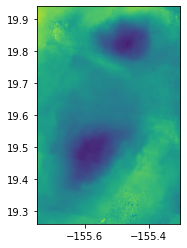

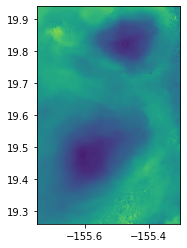

In [76]:
for r in results:
    rasterio.plot.show(rasterio.open(r.result()))

#### Now, STAC inspection and s3 retrieval:

As a user in the cloud, I want to access those data seamlessly using the AWS credentials provided from the Harmony job response

Coming soon: As a user, I want the Harmony library to provide me with the appropriate output URL depending on whether I'm working within or outside of AWS us-west-2

In [65]:
stac_catalog_url = harmony_client.stac_catalog_url(job_id, show_progress=True)
stac_catalog_url

 [ Processing: 100% ] |###################################################| [|]


'https://harmony.earthdata.nasa.gov/stac/e155c257-cfeb-4435-b1f6-71ff4a4207a4/'

Following the directions for PySTAC (https://pystac.readthedocs.io/en/latest/quickstart.html), we can hook our harmony-py client into STAC_IO.

In [66]:
from urllib.parse import urlparse
import requests
from pystac import STAC_IO

def requests_read_method(uri):
    parsed = urlparse(uri)
    if parsed.hostname.startswith('harmony.'):
        return harmony_client.read_text(uri)
    else:
        return STAC_IO.default_read_text_method(uri)

STAC_IO.read_text_method = requests_read_method

In [67]:
from pystac import Catalog

cat = Catalog.from_file(stac_catalog_url)

print(cat.title)
for item in cat.get_all_items():
    print(item.datetime, [asset.href for asset in item.assets.values()])

Harmony output for e155c257-cfeb-4435-b1f6-71ff4a4207a4
2020-02-24 16:15:33.386000+00:00 ['s3://harmony-prod-staging/public/asfdataservices/gdal-subsetter/67c5288a-3deb-44c0-a0a4-5d8f9a878a0a/S1-GUNW-D-R-087-tops-20200224_20200206-161546-20645N_18638N-PP-8677-v2_0_2_science_grids_data_unwrappedPhase_subsetted.tif']
2020-02-24 16:15:33.386000+00:00 ['s3://harmony-prod-staging/public/asfdataservices/gdal-subsetter/67c5288a-3deb-44c0-a0a4-5d8f9a878a0a/S1-GUNW-D-R-087-tops-20200224_20200212-161546-20645N_18638N-PP-2c6e-v2_0_2_science_grids_data_unwrappedPhase_subsetted.tif']


#### Alternatively, we can use intake-stac:

In [68]:
!{sys.executable} -m pip install intake-stac # if you don't already have intake-stac
import intake

In [69]:
# stac_cat = intake.open_stac_catalog(stac_root.format(jobID=job,item=''),name='Harmony output')
cat = intake.open_stac_catalog(stac_catalog_url)
display(list(cat))

['e155c257-cfeb-4435-b1f6-71ff4a4207a4_0',
 'e155c257-cfeb-4435-b1f6-71ff4a4207a4_1']

In [70]:
entries = []
for id, entry in cat.search('type').items():
    display(entry)
    entries.append(entry)

? s3://harmony-prod-staging/public/asfdataservices/gdal-subsetter/67c5288a-3deb-44c0-a0a4-5d8f9a878a0a/S1-GUNW-D-R-087-tops-20200224_20200206-161546-20645N_18638N-PP-8677-v2_0_2_science_grids_data_unwrappedPhase_subsetted.tif
: args:
    chunks: {}
    urlpath: s3://harmony-prod-staging/public/asfdataservices/gdal-subsetter/67c5288a-3deb-44c0-a0a4-5d8f9a878a0a/S1-GUNW-D-R-087-tops-20200224_20200206-161546-20645N_18638N-PP-8677-v2_0_2_science_grids_data_unwrappedPhase_subsetted.tif
  description: S1-GUNW-D-R-087-tops-20200224_20200206-161546-20645N_18638N-PP-8677-v2_0_2_science_grids_data_unwrappedPhase_subsetted.tif
  driver: intake_xarray.raster.RasterIOSource
  metadata:
    catalog_dir: ''
    href: s3://harmony-prod-staging/public/asfdataservices/gdal-subsetter/67c5288a-3deb-44c0-a0a4-5d8f9a878a0a/S1-GUNW-D-R-087-tops-20200224_20200206-161546-20645N_18638N-PP-8677-v2_0_2_science_grids_data_unwrappedPhase_subsetted.tif
    plots:
      geotiff:
        cmap: viridis
        data_asp

? s3://harmony-prod-staging/public/asfdataservices/gdal-subsetter/67c5288a-3deb-44c0-a0a4-5d8f9a878a0a/S1-GUNW-D-R-087-tops-20200224_20200212-161546-20645N_18638N-PP-2c6e-v2_0_2_science_grids_data_unwrappedPhase_subsetted.tif
: args:
    chunks: {}
    urlpath: s3://harmony-prod-staging/public/asfdataservices/gdal-subsetter/67c5288a-3deb-44c0-a0a4-5d8f9a878a0a/S1-GUNW-D-R-087-tops-20200224_20200212-161546-20645N_18638N-PP-2c6e-v2_0_2_science_grids_data_unwrappedPhase_subsetted.tif
  description: S1-GUNW-D-R-087-tops-20200224_20200212-161546-20645N_18638N-PP-2c6e-v2_0_2_science_grids_data_unwrappedPhase_subsetted.tif
  driver: intake_xarray.raster.RasterIOSource
  metadata:
    catalog_dir: ''
    href: s3://harmony-prod-staging/public/asfdataservices/gdal-subsetter/67c5288a-3deb-44c0-a0a4-5d8f9a878a0a/S1-GUNW-D-R-087-tops-20200224_20200212-161546-20645N_18638N-PP-2c6e-v2_0_2_science_grids_data_unwrappedPhase_subsetted.tif
    plots:
      geotiff:
        cmap: viridis
        data_asp

In [72]:
da = cat[list(cat)[0]][entries[0].describe()['name']].to_dask()
da

#### AWS credential retrieval

In [ ]:
creds = harmony_client.aws_credentials()
creds

In [ ]:
#
# NOTE: Execution of this cell will only succeed within the AWS us-west-2 region. 
#

import boto3

s3 = boto3.client('s3', **creds)
uri = 's3://harmony-uat-staging/public/harmony/netcdf-to-zarr/817a3e99-d53c-4169-b9f1-82cc947793be/2020_01_01_7f00ff_global.zarr'
bucket_name = uri.split('/')[2]
object_name = '/'.join(uri.split('/')[3:])
file_name = uri.split('/')[-1]

with open(file_name, 'wb') as f:
    # should return a 403 Forbidden if run outside of us-west-2
    s3.download_fileobj(bucket_name, object_name, f)



#### test examples

In [ ]:
harmony_client = Client()
request = Request(
    collection=Collection(id='C1234088182-EEDTEST'),
#    collection=Collection(id='SENTINEL-1_INTERFEROGRAMS'),
    spatial=BBox(-165, 52, -140, 77),
    temporal={
        'start': dt.datetime(2010, 1, 1),
        'stop': dt.datetime(2020, 12, 30)
    },
    variables=['blue_var'],
    max_results=1,
)
job_id = harmony_client.submit(request)
print(job_id)
results = harmony_client.download_all(job_id, directory='/tmp', overwrite=True)
for r in results:
    rasterio.plot.show(rasterio.open(r.result()))

In [ ]:
harmony_client = Client()
request = Request(
    collection=Collection(id='C1234088182-EEDTEST'),
    max_results=1,
)


In [ ]:
job_id = harmony_client.submit(request)
print(job_id)


In [ ]:
results = harmony_client.download_all(job_id, directory='/tmp', overwrite=True)
for r in results:
    rasterio.plot.show(rasterio.open(r.result()))

In [ ]:
harmony_client.result_json(job_id)

In [ ]:
JSON(harmony_client.status(job_id))